# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Wed Feb 21 13:21:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 6.0 MB/s eta 0:00:00


In [3]:
# Import torch
import torch
from torch import nn
import torchmetrics

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [4]:
# 1. Get data
!gdown 1BdAT7rqGf-Yo0sft0HTea8eqjnGFZAEu
!unzip -q pizza_steak_sushi.zip -d pizza_steak_sushi

Downloading...
From: https://drive.google.com/uc?id=1BdAT7rqGf-Yo0sft0HTea8eqjnGFZAEu
To: /content/pizza_steak_sushi.zip
100% 15.7M/15.7M [00:00<00:00, 201MB/s]


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir('pizza_steak_sushi/')

There are 2 directories and 0 images in 'pizza_steak_sushi/'.
There are 3 directories and 0 images in 'pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'pizza_steak_sushi/train/sushi'.


In [6]:
# Setup train and testing paths
train_path = 'pizza_steak_sushi/train'
test_path = 'pizza_steak_sushi/test'

classes = os.listdir(train_path)
idx_to_class = {}

for i, class_name in enumerate(classes):
  idx_to_class[i] = class_name

classes, idx_to_class

(['pizza', 'steak', 'sushi'], {0: 'pizza', 1: 'steak', 2: 'sushi'})

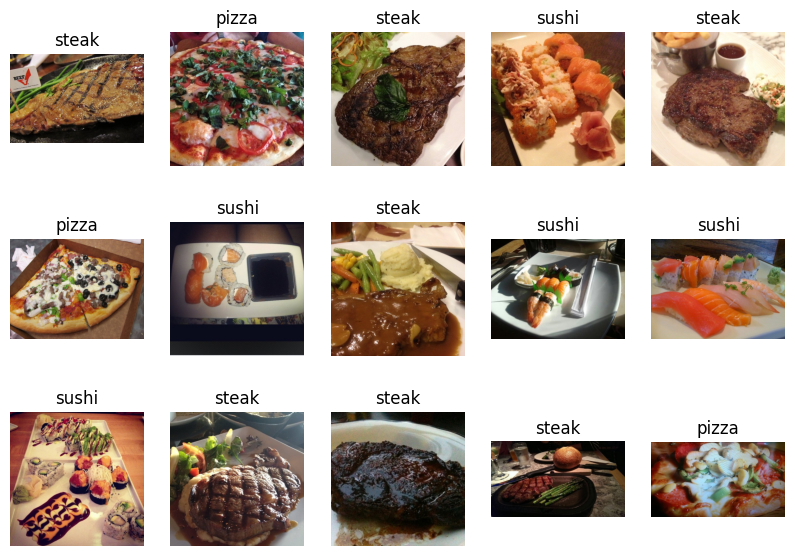

In [7]:
# Visualize images

import matplotlib.pyplot as plt
from PIL import Image

# torch.manual_seed(42)

random_class = torch.randint(0, len(classes), (15,))

plt.figure(figsize=(10, 7))
idx = 1
n_rows, n_columns = 3, 5

for i in range(random_class.shape[0]):

  class_name = idx_to_class[random_class[i].item()]
  images = os.listdir(train_path + '/' + class_name)
  random_img = torch.randint(0, len(images), (1,))

  img = f"{train_path}/{class_name}/{images[random_img.item()]}"

  opened_img = Image.open(img)

  plt.subplot(n_rows, n_columns, idx)
  plt.imshow(opened_img)
  plt.axis(False)
  plt.title(class_name)

  idx += 1

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms


In [9]:
# Write transform for turning images into tensors
from torchvision.transforms import v2

transformer = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
def get_random_img_path(folder, random_seed = None):

  if random_seed:
    torch.manual_seed(random_seed)

  random_class = torch.randint(0, len(classes), (1,))
  class_name = idx_to_class[random_class.item()]

  images = os.listdir(train_path + '/' + class_name)
  random_img = torch.randint(0, len(images), (1,))

  return f"{train_path}/{class_name}/{images[random_img.item()]}"

In [11]:
get_random_img_path(train_path)

'pizza_steak_sushi/train/steak/1382427.jpg'

In [12]:
# Write a function to plot transformed images

def plot_transformed_img(img_path, transformer):
  img = Image.open(img_path)
  transformed_img = transformer(img)

  n_rows, n_columns = 1, 2
  plt.figure(figsize=(10,7))

  plt.subplot(n_rows, n_columns, 1)
  plt.imshow(img)
  plt.axis(False)
  plt.title("Imagen original")

  plt.subplot(n_rows, n_columns, 2)
  plt.imshow(transformed_img.permute(1,2,0))
  plt.axis(False)
  plt.title("Imagen transformada");

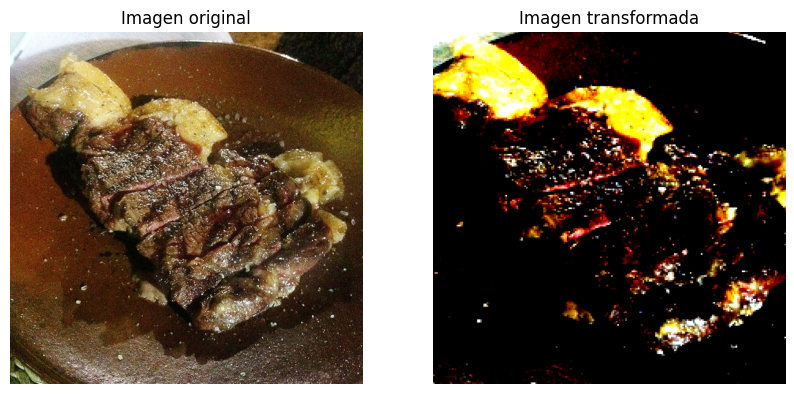

In [13]:
plot_transformed_img(get_random_img_path(train_path), transformer)

### Load image data using `ImageFolder`

In [14]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_data = ImageFolder(train_path, transform=transformer)
test_data = ImageFolder(test_path, transform=transformer)

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 8

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE)

In [19]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(29, 10)

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [20]:
import torch.nn as nn

class FoodClassifierModel(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_features, kernel_size):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_channels*23*23, out_features),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    return self.classifier(x)

In [21]:
model = FoodClassifierModel(3, 64, len(class_names), 3).to(device)

model

FoodClassifierModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33856, out_features=3, bias=True)
  )
)

In [22]:
dummy_data = torch.randn(size=(3,224,224)).unsqueeze(dim=0).to(device)

model(dummy_data)

tensor([[-0.0073, -0.0112,  0.0002]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [23]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               softmax:  torch.nn.Softmax,
               accuracy_fn: torchmetrics.Accuracy):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for X, y in dataloader:
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_logits = model(X)
    y_preds = torch.argmax(softmax(y_logits), dim=1)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_logits, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_acc += accuracy_fn(y_preds, y)


  # Adjust metrics to get average loss and average accuracy per batch
  total_loss = train_loss / len(dataloader)
  total_acc = train_acc / len(dataloader)

  return total_loss, total_acc

In [24]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              softmax:  torch.nn.Softmax,
              accuracy_fn: torchmetrics.Accuracy):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for X, y in dataloader:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_logits = model(X)
      y_preds = torch.argmax(softmax(y_logits), dim=1)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(y_logits, y)
      test_loss += loss

      # Calculate and accumulate accuracy
      test_acc += accuracy_fn(y_preds, y)

  # Adjust metrics to get average loss and accuracy per batch
  total_loss = test_loss / len(dataloader)
  total_acc = test_acc / len(dataloader)

  return total_loss, total_acc

In [25]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          softmax:  torch.nn.Softmax,
          accuracy_fn: torchmetrics.Accuracy,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       softmax=softmax,
                                       accuracy_fn=accuracy_fn)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    softmax=softmax,
                                    accuracy_fn=accuracy_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [26]:
softmax = nn.Softmax(dim=1)
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [30]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

results_5_epochs = train(model,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        softmax,
                        accuracy_fn,
                        loss_fn,
                        epochs = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1104 | train_acc: 0.4526 | test_loss: 1.0858 | test_acc: 0.4125
Epoch: 2 | train_loss: 0.9846 | train_acc: 0.5043 | test_loss: 0.9869 | test_acc: 0.4792
Epoch: 3 | train_loss: 0.9376 | train_acc: 0.5216 | test_loss: 1.0082 | test_acc: 0.4458
Epoch: 4 | train_loss: 0.9547 | train_acc: 0.5388 | test_loss: 1.3554 | test_acc: 0.3125
Epoch: 5 | train_loss: 0.8835 | train_acc: 0.5948 | test_loss: 1.1706 | test_acc: 0.4125


In [31]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

results_20_epochs = train(model,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        softmax,
                        accuracy_fn,
                        loss_fn,
                        epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0014 | train_acc: 0.5216 | test_loss: 0.9533 | test_acc: 0.5292
Epoch: 2 | train_loss: 0.8602 | train_acc: 0.5733 | test_loss: 1.0391 | test_acc: 0.5042
Epoch: 3 | train_loss: 0.8691 | train_acc: 0.5905 | test_loss: 1.0255 | test_acc: 0.4000
Epoch: 4 | train_loss: 0.8613 | train_acc: 0.6379 | test_loss: 1.2754 | test_acc: 0.4125
Epoch: 5 | train_loss: 0.8385 | train_acc: 0.6336 | test_loss: 1.0296 | test_acc: 0.4708
Epoch: 6 | train_loss: 0.8004 | train_acc: 0.6595 | test_loss: 1.1906 | test_acc: 0.4375
Epoch: 7 | train_loss: 0.8381 | train_acc: 0.5948 | test_loss: 1.2585 | test_acc: 0.5167
Epoch: 8 | train_loss: 0.7882 | train_acc: 0.6164 | test_loss: 1.1261 | test_acc: 0.5708
Epoch: 9 | train_loss: 0.8649 | train_acc: 0.6121 | test_loss: 1.2439 | test_acc: 0.4458
Epoch: 10 | train_loss: 0.8378 | train_acc: 0.6422 | test_loss: 0.9679 | test_acc: 0.5292
Epoch: 11 | train_loss: 0.7941 | train_acc: 0.6897 | test_loss: 1.0185 | test_acc: 0.6500
Epoch: 12 | train_l

In [29]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

results_50_epochs = train(model,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        softmax,
                        accuracy_fn,
                        loss_fn,
                        epochs = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5441 | train_acc: 0.7802 | test_loss: 0.8703 | test_acc: 0.6167
Epoch: 2 | train_loss: 0.5348 | train_acc: 0.8060 | test_loss: 0.9298 | test_acc: 0.6917
Epoch: 3 | train_loss: 0.5468 | train_acc: 0.7888 | test_loss: 0.9402 | test_acc: 0.6292
Epoch: 4 | train_loss: 0.5421 | train_acc: 0.7500 | test_loss: 1.4766 | test_acc: 0.4875
Epoch: 5 | train_loss: 0.5313 | train_acc: 0.8060 | test_loss: 1.0917 | test_acc: 0.6083
Epoch: 6 | train_loss: 0.5852 | train_acc: 0.7543 | test_loss: 0.9836 | test_acc: 0.5583
Epoch: 7 | train_loss: 0.5660 | train_acc: 0.7845 | test_loss: 1.1864 | test_acc: 0.6750
Epoch: 8 | train_loss: 0.4923 | train_acc: 0.8405 | test_loss: 0.9844 | test_acc: 0.7000
Epoch: 9 | train_loss: 0.5448 | train_acc: 0.7931 | test_loss: 1.1399 | test_acc: 0.5792
Epoch: 10 | train_loss: 0.5247 | train_acc: 0.7974 | test_loss: 0.9989 | test_acc: 0.6208
Epoch: 11 | train_loss: 0.5461 | train_acc: 0.7845 | test_loss: 0.7298 | test_acc: 0.7625
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [28]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = FoodClassifierModel(3, 128, len(class_names), 3).to(device)

model_1

FoodClassifierModel(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=67712, out_features=3, bias=True)
  )
)

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

results_20_epochs_double_hidden_units = train(model_1,
                                              train_dataloader,
                                              test_dataloader,
                                              optimizer,
                                              softmax,
                                              accuracy_fn,
                                              loss_fn,
                                              epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0993 | train_acc: 0.2284 | test_loss: 1.1024 | test_acc: 0.2250
Epoch: 2 | train_loss: 1.0989 | train_acc: 0.3147 | test_loss: 1.1027 | test_acc: 0.2625
Epoch: 3 | train_loss: 1.0989 | train_acc: 0.3017 | test_loss: 1.1015 | test_acc: 0.2125
Epoch: 4 | train_loss: 1.0995 | train_acc: 0.2155 | test_loss: 1.1016 | test_acc: 0.3000
Epoch: 5 | train_loss: 1.0999 | train_acc: 0.3060 | test_loss: 1.1032 | test_acc: 0.1500
Epoch: 6 | train_loss: 1.0988 | train_acc: 0.2759 | test_loss: 1.1040 | test_acc: 0.2000
Epoch: 7 | train_loss: 1.0996 | train_acc: 0.3190 | test_loss: 1.1025 | test_acc: 0.2000
Epoch: 8 | train_loss: 1.0994 | train_acc: 0.3147 | test_loss: 1.1030 | test_acc: 0.2250
Epoch: 9 | train_loss: 1.0978 | train_acc: 0.3147 | test_loss: 1.1025 | test_acc: 0.2375
Epoch: 10 | train_loss: 1.0983 | train_acc: 0.3017 | test_loss: 1.1025 | test_acc: 0.2250
Epoch: 11 | train_loss: 1.0986 | train_acc: 0.3190 | test_loss: 1.1041 | test_acc: 0.2500
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [27]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [28]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.


Excellent, we now have double the training and testing images...

In [29]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [30]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

# Create datasets
train_dataset = ImageFolder(train_data_20_percent_path,
                               transform = simple_transform)

test_dataset = ImageFolder(test_data_20_percent_path,
                               transform = simple_transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset,
                              BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                              BATCH_SIZE,
                              shuffle=False)

In [31]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = FoodClassifierModel(3, 64, len(class_names), 3).to(device)

model_2

FoodClassifierModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33856, out_features=3, bias=True)
  )
)

In [41]:
dummy_data = torch.randn(size=(3,224,224)).unsqueeze(dim=0).to(device)

model_2(dummy_data)

tensor([[ 0.0338, -0.0398, -0.0882]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

results_10_epochs_new_dataset = train(model_2,
                                      train_dataloader,
                                      test_dataloader,
                                      optimizer,
                                      softmax,
                                      accuracy_fn,
                                      loss_fn,
                                      epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0986 | train_acc: 0.3355 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 2 | train_loss: 1.0985 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 3 | train_loss: 1.0986 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 4 | train_loss: 1.0985 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 7 | train_loss: 1.0986 | train_acc: 0.3355 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 8 | train_loss: 1.0986 | train_acc: 0.3355 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 9 | train_loss: 1.0986 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026
Epoch: 10 | train_loss: 1.0985 | train_acc: 0.3421 | test_loss: 1.0988 | test_acc: 0.3026


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [39]:
img_predict = Image.open('pizza.jpeg')

img_transformed = simple_transform(img_predict).to(device).unsqueeze(dim=0)

with torch.inference_mode():

  y_logits = model_2(img_transformed)
  y_preds = torch.argmax(softmax(y_logits), dim=1)

idx_to_class[y_preds.item()]

'pizza'